## Loading of Stringer orientations data

includes some visualizations

In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


In [4]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(23589, 4598)
23589


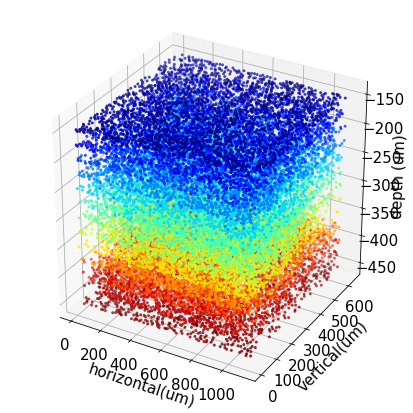

In [5]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

In [6]:
dat['run'].shape

(4598,)

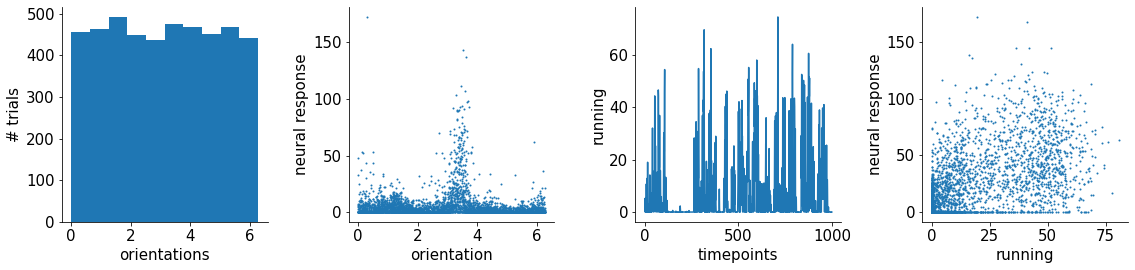

In [7]:
#@title Basic data properties using plot, hist and scatter
ax = plt.subplot(1,5,1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel = '# trials')

ax = plt.subplot(1,5,2)
plt.scatter(dat['istim'], dat['sresp'][1000], s= 1)
ax.set(xlabel = 'orientation', ylabel = 'neural response')

ax = plt.subplot(1,5,3)
plt.plot(dat['run'][:1000])
ax.set(xlabel = 'timepoints', ylabel = 'running')

ax = plt.subplot(1,5,4)
plt.scatter(dat['run'], dat['sresp'][20998], s= 1)
ax.set(xlabel = 'running', ylabel = 'neural response')

plt.show()

In [8]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
X = PCA(n_components = 200).fit_transform(Z.T)

In [9]:
X.shape

(4598, 200)

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


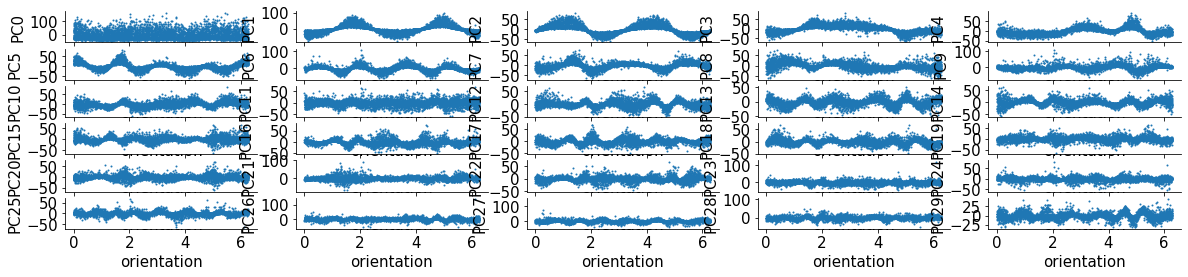

In [53]:
#@title plot PCs as function of stimulus orientation
n = 30
for j in range(n):
  ax = plt.subplot(n/5,5,j+1)
  plt.scatter(dat['istim'], X[:,j], s = 1)
  ax.set(xlabel='orientation', ylabel = 'PC%d'%j)
plt.show()

In [11]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions. 
# !pip install umap-learn
from umap import UMAP
ncomp = 3 # try 2, then try 3
xinit = 3 * zscore(X[:,:ncomp], axis=0)
embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 25, 
             metric = 'correlation', transform_seed = 42).fit_transform(X)

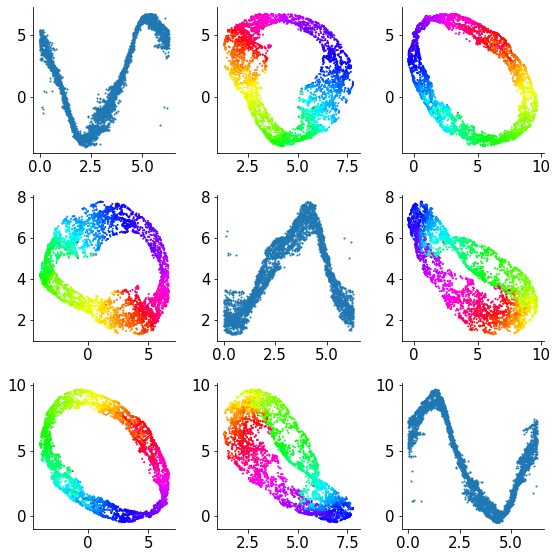

In [12]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i==j:
      plt.scatter(dat['istim'], embed[:,i], s  = 1)
    else:
      plt.scatter(embed[:,j], embed[:,i], s  = 1, c= dat['istim'], cmap = 'hsv')
# Is that a Mobius strip? A good project would be to try to figure out why (I don't know). 

In [13]:
# Mind readers analysis

In [14]:
# Import libraries

import numpy as np
import scipy.stats

import sklearn.decomposition 
import sklearn.model_selection
import sklearn.pipeline
import sklearn.linear_model
import sklearn.metrics

In [16]:
rng = np.random.RandomState(0)
train_size = 0.7

In [17]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dat['sresp'].T, dat['istim'], train_size=train_size, random_state=rng)
Z_train = scipy.stats.zscore(X_train, axis=1)
Z_test = scipy.stats.zscore(X_test, axis=1)

In [29]:
pipe = sklearn.pipeline.Pipeline([
                                  ('pca', sklearn.decomposition.PCA(n_components=200)),
                                  ('linear_regression', sklearn.linear_model.LinearRegression(fit_intercept=True))
                                 ])

In [31]:
# This is the code needed to replicate what a pipeline does
# Pipeline is a wrapper around the individual components
# so they can be treated as a single unit

# pca = sklearn.decomposition.PCA(n_components=200)
# pca.fit(Z_train, y_train)
# P = pca.transform(Z_train)
# print(P.shape)
# glm = sklearn.linear_model.LinearRegression(fit_intercept=True)
# glm.fit(P, y_train)
# y_pred = glm.predict(Z_test)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [54]:
params = scipy.stats.vonmises.fit(P, fscale=1)
print(params)

(0.003710937499999115, -1.220942857540155e-15, 1)


In [41]:
pipe.fit(Z_train, y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linear_regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [42]:
y_pred = pipe.predict(Z_test)

In [58]:
f"""
Components is a matrix of shape {pipe.named_steps['pca'].components_.shape}
encoding 
""".replace("\n", " ")

' Components is a matrix of shape (200, 23589) encoding the contribution (weight) of each eigen neuron to drive the predicted angle '

In [43]:
# mean squared error
sklearn.metrics.mean_squared_error(y_test, y_pred)

0.4483579464245238

In [ ]:
# Training set

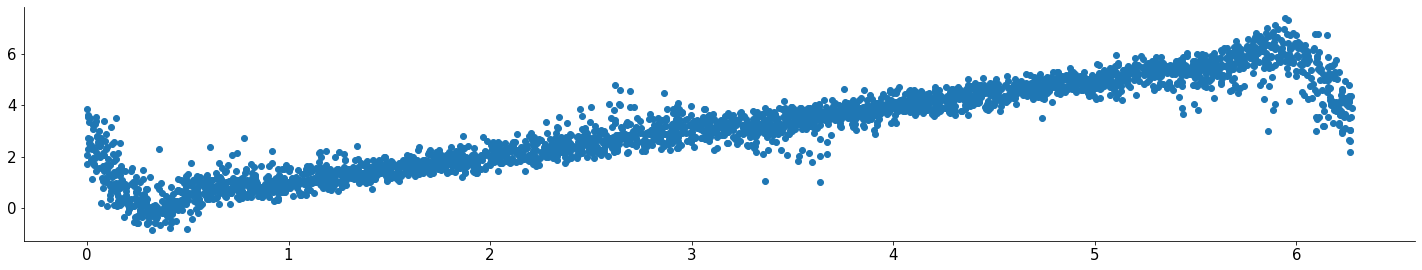

In [49]:
plt.scatter(x=y_train, y=pipe.predict(Z_train))

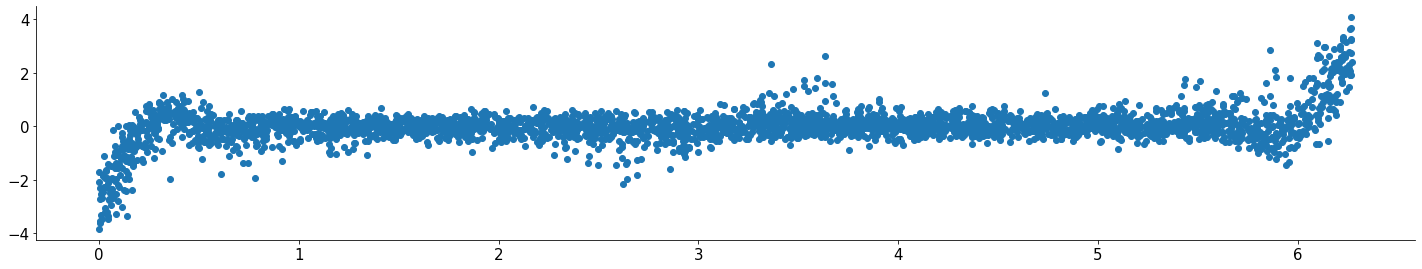

In [50]:
plt.scatter(x=y_train, y=y_train - pipe.predict(Z_train))

In [ ]:
# Test set

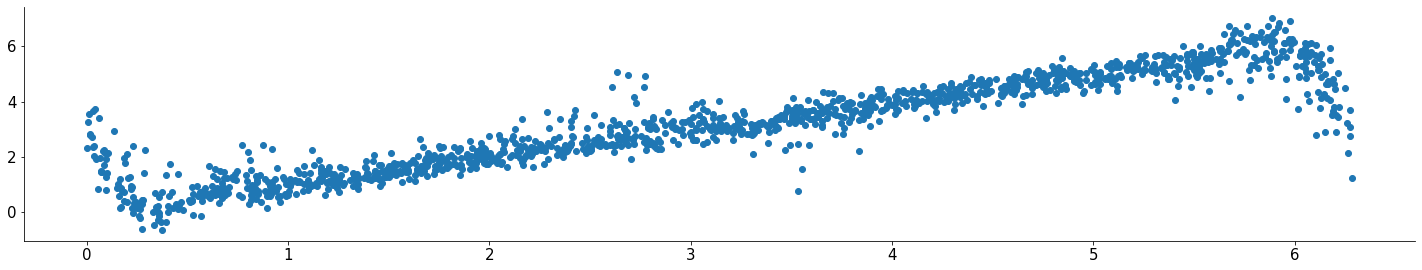

In [51]:
plt.scatter(y_test, y_pred)

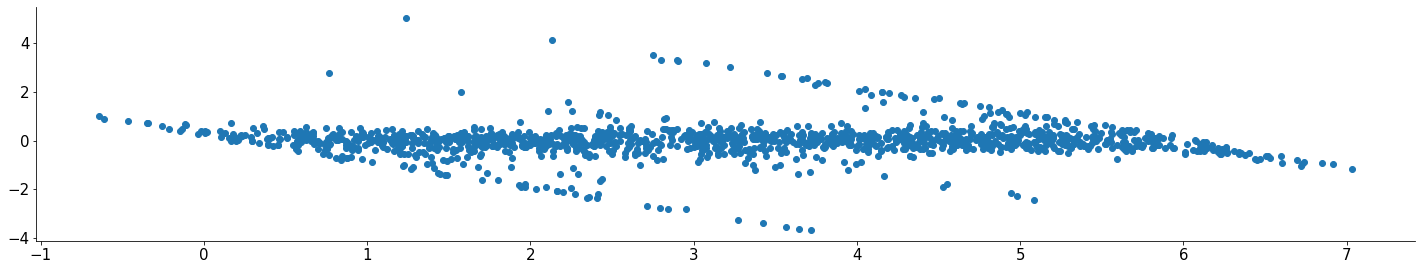

In [45]:
plt.scatter(y_pred, y_test - y_pred)

<BarContainer object of 3218 artists>

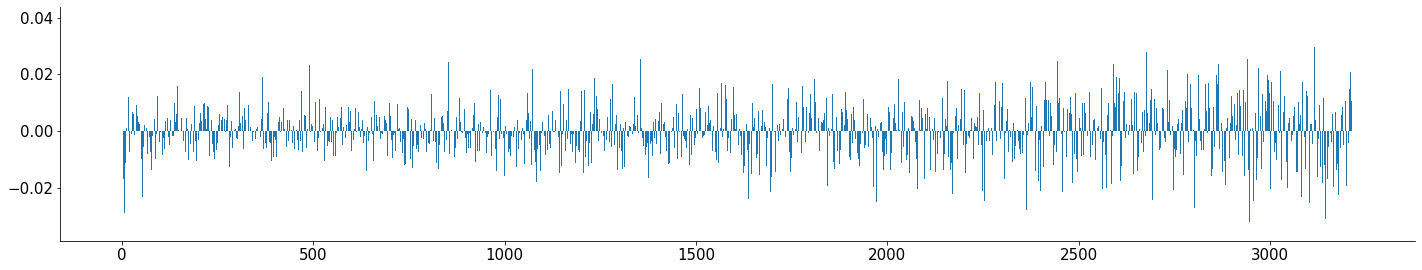

In [ ]:
plt.bar(x=np.arange(coef.shape[0]), height=coef.flatten())